# Mock environment

define a simple grid where the agent can move freely
actionspace = (0,1,2,3)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mango import MangoEnvironment
from actions import *
from states import *

In [2]:
class Environment():
    def __init__(self):
        self.reset()
        self.actionspace = [0,1,2,3]
    
    def reset(self):
        self.x, self.y = 0,0
        self.render()
        return self.get_state()
    
    def get_state(self):
        state = torch.zeros((8,8))
        state[self.x,self.y] = 1
        return torch.Tensor(state)
        
    def step(self,action):
        if action == 0:
            self.x = min((max((self.x+1, 0)),7))
        if action == 1:
            self.y = min((max((self.y+1, 0)),7))
        if action == 2:
            self.x = min((max((self.x-1, 0)),7))
        if action == 3:
            self.y = min((max((self.y-1, 0)),7))
        self.render()
        return self.get_state(), "reward", "terminated", "truncated"
    
    def render(self):
        plt.imshow(self.get_state())

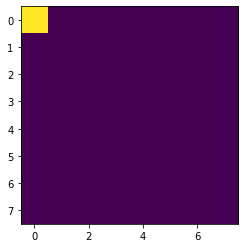

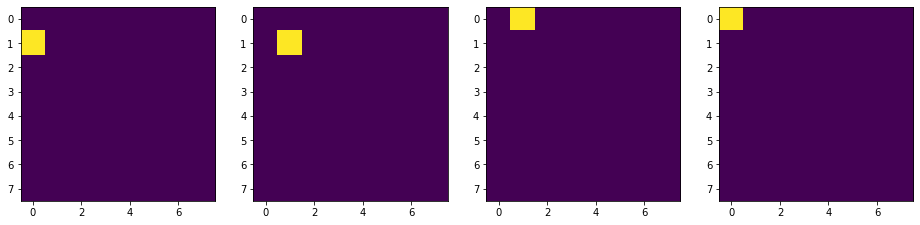

In [3]:
# test the mango env wrapper
mangoenv = MangoEnvironment(Environment(),TensorState)

plt.figure(figsize=(16,8))
for i in range(4):    
    plt.subplot(1,4,i+1)
    state = mangoenv(i)

# Test Abstraction 

example abstraction = zoomed out wiew, lowres positional encoding

In [4]:
from abstraction import AbstractionBuffer,StateAbstractor

In [5]:
class ZoomOutStateAbstractor(StateAbstractor):
    def abstract(self, state):
        state = state.repr
        state_prime = torch.zeros(((state.shape[0]//2,state.shape[1]//2)))
        for x in range(state_prime.shape[0]):
            for y in range(state_prime.shape[1]):
                state_prime[x,y] = torch.sum(state[2*x:2*x+2,2*y:2*y+2])
        return TensorState(state_prime)             

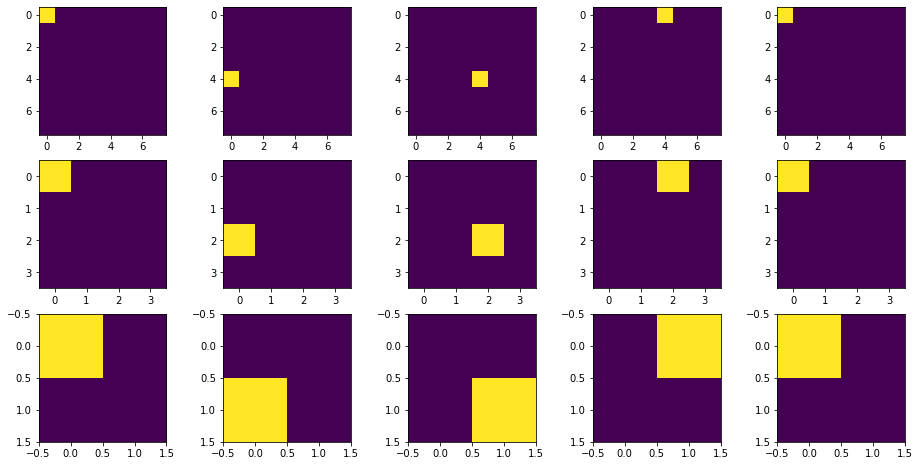

In [6]:
abstractor = ZoomOutStateAbstractor()

state_prime = abstractor(state)
state_double_prime = abstractor(state_prime)

plt.figure(figsize=(16,8))
plt.subplot(3,5,1)
mangoenv.env.render()
plt.subplot(3,5,5+1)
plt.imshow(state_prime.repr)
plt.subplot(3,5,10+1)
plt.imshow(state_double_prime.repr)
for i in range(4):
    plt.subplot(3,5,i+2)
    for _ in range(4):
        state = mangoenv(i) 
    state_prime = abstractor(state)
    state_double_prime = abstractor(state_prime)
    
    plt.subplot(3,5,5+i+2)
    plt.imshow(state_prime.repr)
    plt.subplot(3,5,10+i+2)
    plt.imshow(state_double_prime.repr) 

old state': [STATE ['(0,0):1.0)'] layerNone]
new state': [STATE ['(0,0):1.0)'] layerNone]
action': [ACTION NULL layerNone]

old state': [STATE ['(0,0):1.0)'] layerNone]
new state': [STATE ['(1,0):1.0)'] layerNone]
action': [ACTION ['(0,0):-1.0)', '(1,0):1.0)'] layerNone]



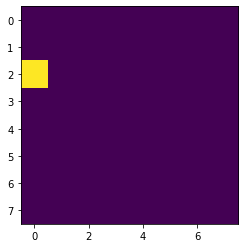

In [7]:
old_state_prime = state_prime
new_state_prime = state_prime
action_prime = abstractor.get_action_prime(old_state_prime,new_state_prime)
print(f"old state': {old_state_prime}")
print(f"new state': {new_state_prime}")
print(f"action': {action_prime}")
print()


state = mangoenv(0)
state = mangoenv(0)
state_prime = abstractor(state)
state_double_prime = abstractor(state_prime)

new_state_prime = state_prime
action_prime = abstractor.get_action_prime(old_state_prime,new_state_prime)
print(f"old state': {old_state_prime}")
print(f"new state': {new_state_prime}")
print(f"action': {action_prime}")
print()

# Test buffer

pushing state [STATE ['(0,0):1.0)'] layerNone]

current state: [STATE ['(0,0):1.0)'] layerNone]
current state': [STATE ['(0,0):1.0)'] layerNone]
action': [ACTION NULL layerNone]


pushing state [STATE ['(1,0):1.0)'] layerNone]

current state: [STATE ['(1,0):1.0)'] layerNone]
current state': [STATE ['(0,0):1.0)'] layerNone]
action': [ACTION NULL layerNone]


pushing state [STATE ['(2,0):1.0)'] layerNone]

current state: [STATE ['(2,0):1.0)'] layerNone]
current state': [STATE ['(1,0):1.0)'] layerNone]
action': [ACTION ['(0,0):-1.0)', '(1,0):1.0)'] layerNone]


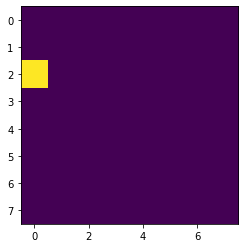

In [8]:
buffer = AbstractionBuffer(abstractor)

mangoenv.reset()
_, state = mangoenv.get_current_state()
action_prime = buffer.push(state)
print(f"pushing state {state}")
print()

state, state_prime = buffer.get_current_state()
print(f"current state: {state}")
print(f"current state': {state_prime}")
print(f"action': {action_prime}")
print()
print()

mangoenv(0)
_, state = mangoenv.get_current_state()

action_prime = buffer.push(state)
print(f"pushing state {state}")
print()

state, state_prime = buffer.get_current_state()
print(f"current state: {state}")
print(f"current state': {state_prime}")
print(f"action': {action_prime}")
print()
print()

mangoenv(0)
_, state = mangoenv.get_current_state()

action_prime = buffer.push(state)
print(f"pushing state {state}")
print()

state, state_prime = buffer.get_current_state()
print(f"current state: {state}")
print(f"current state': {state_prime}")
print(f"action': {action_prime}")

# Test policy

In [9]:
from policies import PolicyStack,Policy

In [10]:
class SimpleNet(torch.nn.Module):
    def __init__(self, x,y):
        super().__init__()
        self.layer = torch.nn.Linear(x*y,4)
        
    def forward(self,x):
        x = torch.flatten(x)
        x = self.layer(x)
        x = -100*torch.ones(4)
        x[0]=100
        return x
SimpleNet(8,8)(torch.zeros((8,8)))

tensor([ 100., -100., -100., -100.])

suggested action: 0


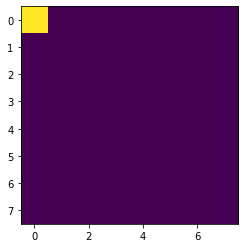

In [11]:
mangoenv.reset()
_, state = mangoenv.get_current_state()
explore_policy = Policy(SimpleNet(8,8))
print(f"suggested action: {explore_policy(state,4)}")

In [12]:
policystack = PolicyStack(explore_policy)
comand = policystack.current_comand
print(f"current command: {comand}")
print()

comand = Action(1)
policystack.add_new_policy(comand)
print(f"adding new policy for command {comand}")
print()

policystack.set_comand(comand)
comand = policystack.current_comand
print(f"current command: {comand}")
print()

current command: [ACTION EXPLORE layerNone]

adding new policy for command [ACTION 1 layerNone]

current command: [ACTION 1 layerNone]



# Test MANGO

In [13]:
from mango import Mango,MangoEnvironment

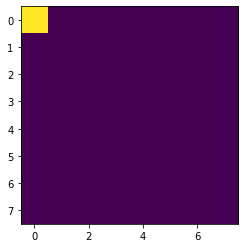

In [14]:
abstractor = ZoomOutStateAbstractor()
mangoenv = MangoEnvironment(Environment(),TensorState)

policystack = PolicyStack(Policy(SimpleNet(8,8)),layer=1)
mango1 = Mango(mangoenv, policystack, abstractor, layer=1)

policystack = PolicyStack(Policy(SimpleNet(4,4)), layer=2)
mango2 = Mango(mango1, policystack, abstractor, layer=2)

In [15]:
print("MANGO ENV")
print(f"learned commands: {[str(c) for c in mangoenv.learned_comands()]}")
print("MANGO 1")
print(f"learned commands: {[str(c) for c in mango1.learned_comands()]}")
print("MANGO 2")
print(f"learned commands: {[str(c) for c in mango2.learned_comands()]}")

MANGO ENV
learned commands: ['0', '1', '2', '3']
MANGO 1
learned commands: ['[ACTION EXPLORE layer1]']
MANGO 2
learned commands: ['[ACTION EXPLORE layer2]']


discovered new action [ACTION ['(0,0):-1.0)', '(1,0):1.0)'] layer1]
discovered new action [ACTION ['(1,0):-1.0)', '(2,0):1.0)'] layer1]
discovered new action [ACTION ['(2,0):-1.0)', '(3,0):1.0)'] layer1]
discovered new action [ACTION ['(0,0):-1.0)', '(1,0):1.0)'] layer2]


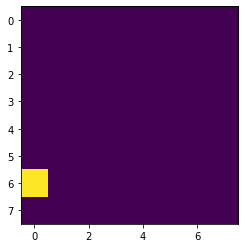

In [16]:
comand = mango2.learned_comands()[0]
state_prime = mango2.handle_abstract_action(comand)

In [17]:
print("MANGO ENV")
for c in mangoenv.learned_comands() :
    print(f"learned command: {str(c)}")
print("\n\nMANGO 1")
for c in mango1.learned_comands() :
    print(f"learned command: {str(c)}")
print("\n\nMANGO 2")
for c in mango2.learned_comands() :
    print(f"learned command: {str(c)}")

MANGO ENV
learned command: 0
learned command: 1
learned command: 2
learned command: 3


MANGO 1
learned command: [ACTION EXPLORE layer1]
learned command: [ACTION ['(0,0):-1.0)', '(1,0):1.0)'] layer1]
learned command: [ACTION ['(1,0):-1.0)', '(2,0):1.0)'] layer1]
learned command: [ACTION ['(2,0):-1.0)', '(3,0):1.0)'] layer1]


MANGO 2
learned command: [ACTION EXPLORE layer2]
learned command: [ACTION ['(0,0):-1.0)', '(1,0):1.0)'] layer2]
